In [2]:
import os
import pathlib
from typing import List, Tuple
from dotenv import load_dotenv
from setup_logger import logger
import cv2 as cv

BASE_DIR = pathlib.Path(__name__).resolve().parent.parent
load_dotenv(BASE_DIR / '.env')
DATA_PATH = pathlib.Path(os.getenv("DATA_PATH"))

In [3]:
import matplotlib.pyplot as plt
import scipy.stats as sps
import numpy as np
import matplotlib.colors as colors
from typing import List, Tuple

## Generate plot data

In [4]:
generated_plots_savepath = DATA_PATH / "generated_plots"

In [4]:
colors_list = list(colors._colors_full_map.values())[:1150]
marker_types = [".", "o", "v", "^", "<", ">", "1", "s", "p", "P", "*", "+", "X", "D", "d"]
marker_sizes = [60, 70, 80, 90, 100, 110]

distributions = [
    sps.uniform(loc=1, scale=8), 
    sps.expon(loc=0, scale=1.5), 
    sps.norm(loc=5, scale=1)
]

In [5]:
def generate_points(n: int, distributions: List):
    distr_x, distr_y = np.random.choice(distributions, size=2)
    x = distr_x.rvs(size=n)
    y = distr_y.rvs(size=n)
    
    return x, y

In [6]:
def generate_single_plot(distributions, colors_list, marker_types, marker_sizes):
    fig = plt.figure(figsize=(8, 8))

    markersize = np.random.choice(marker_sizes)
    all_points = []

    for j in range(3):
        x, y = generate_points(50, distributions)
        points_single_marker = np.stack((x, y)).T

        color = np.random.choice(colors_list)
        marker = np.random.choice(marker_types)
        plt.scatter(x, y,
                    s=markersize,
                    c=color,
                    marker=marker,
                    cmap=None,
                    edgecolors='black',
                    linewidths=0.6,
                    label=f"Label {j}")
        all_points.append(points_single_marker)
    plt.title("Title")
    plt.xlabel("X label")
    plt.ylabel("Y label")
    plt.xlim(-1, 10)
    plt.ylim(-1, 10)
    plt.grid()
    plt.legend()

    return fig, all_points

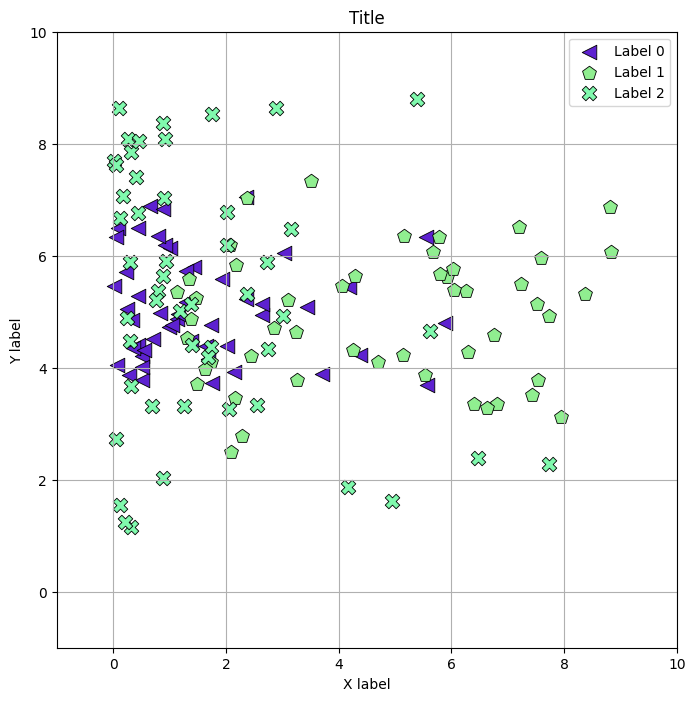

In [7]:
fig, all_points = generate_single_plot(distributions, colors_list, marker_types, marker_sizes)

**Generate many plots**

In [17]:
def coordinates_to_px(x, y):
    delta_x = 113
    delta_y = 32
    s_x = 56.4
    s_y = 56
    max_y = 10

    x_px = delta_x + x * s_x
    y_px = delta_y + (max_y - y) * s_y
    return x_px, y_px

/tmp/ipykernel_42391/473027804.py:13: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x, y,


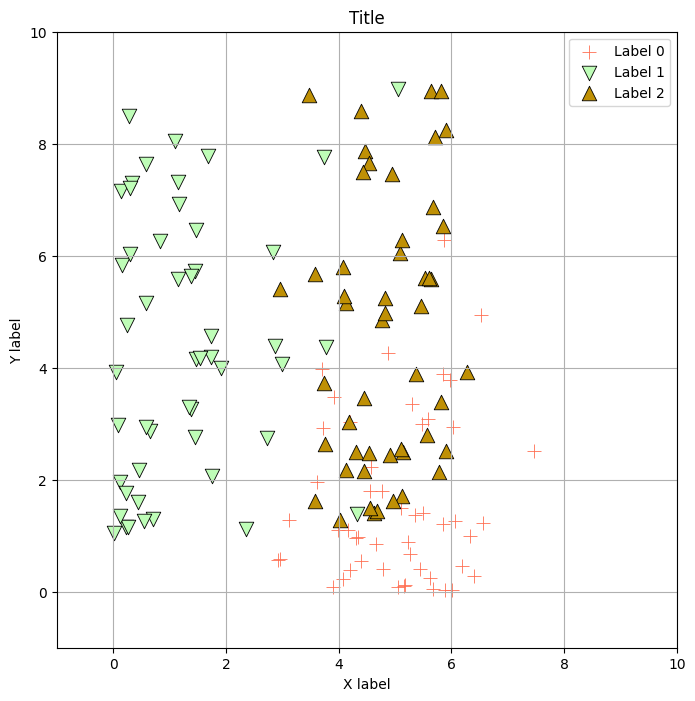

In [19]:
for i in range(16, 17):
    fig, all_points = generate_single_plot(distributions, colors_list, marker_types, marker_sizes)

    for marker_num in range(len(all_points)):
        marker_points = all_points[marker_num]

        x, y = marker_points[:, 0], marker_points[:, 1]
        x_px, y_px = coordinates_to_px(x, y)
        marker_points_px = np.stack((x_px, y_px)).T

        np.savetxt(
            generated_plots_savepath / f"plot_{i}_coordinates_marker_{marker_num}.csv",
            marker_points_px,
            delimiter=",")
    fig.savefig(generated_plots_savepath / f"plot_{i}.png", bbox_inches="tight")

## Map generated points coordinates to pixel coordinates

In [123]:
points = np.loadtxt(
    generated_plots_savepath / "plot_0_coordinates_marker_0.csv", 
    dtype=np.float64, 
    delimiter=","
)

In [126]:
# x, y = points[:, 0], points[:, 1]

# # podgon
# delta_x = 113
# delta_y = 32
# s_x = 56.4
# s_y = 56
# max_y = 10

# x = delta_x + x * s_x
# y = delta_y + (max_y - y) * s_y

In [127]:
img = plt.imread(generated_plots_savepath / "plot_0.png")

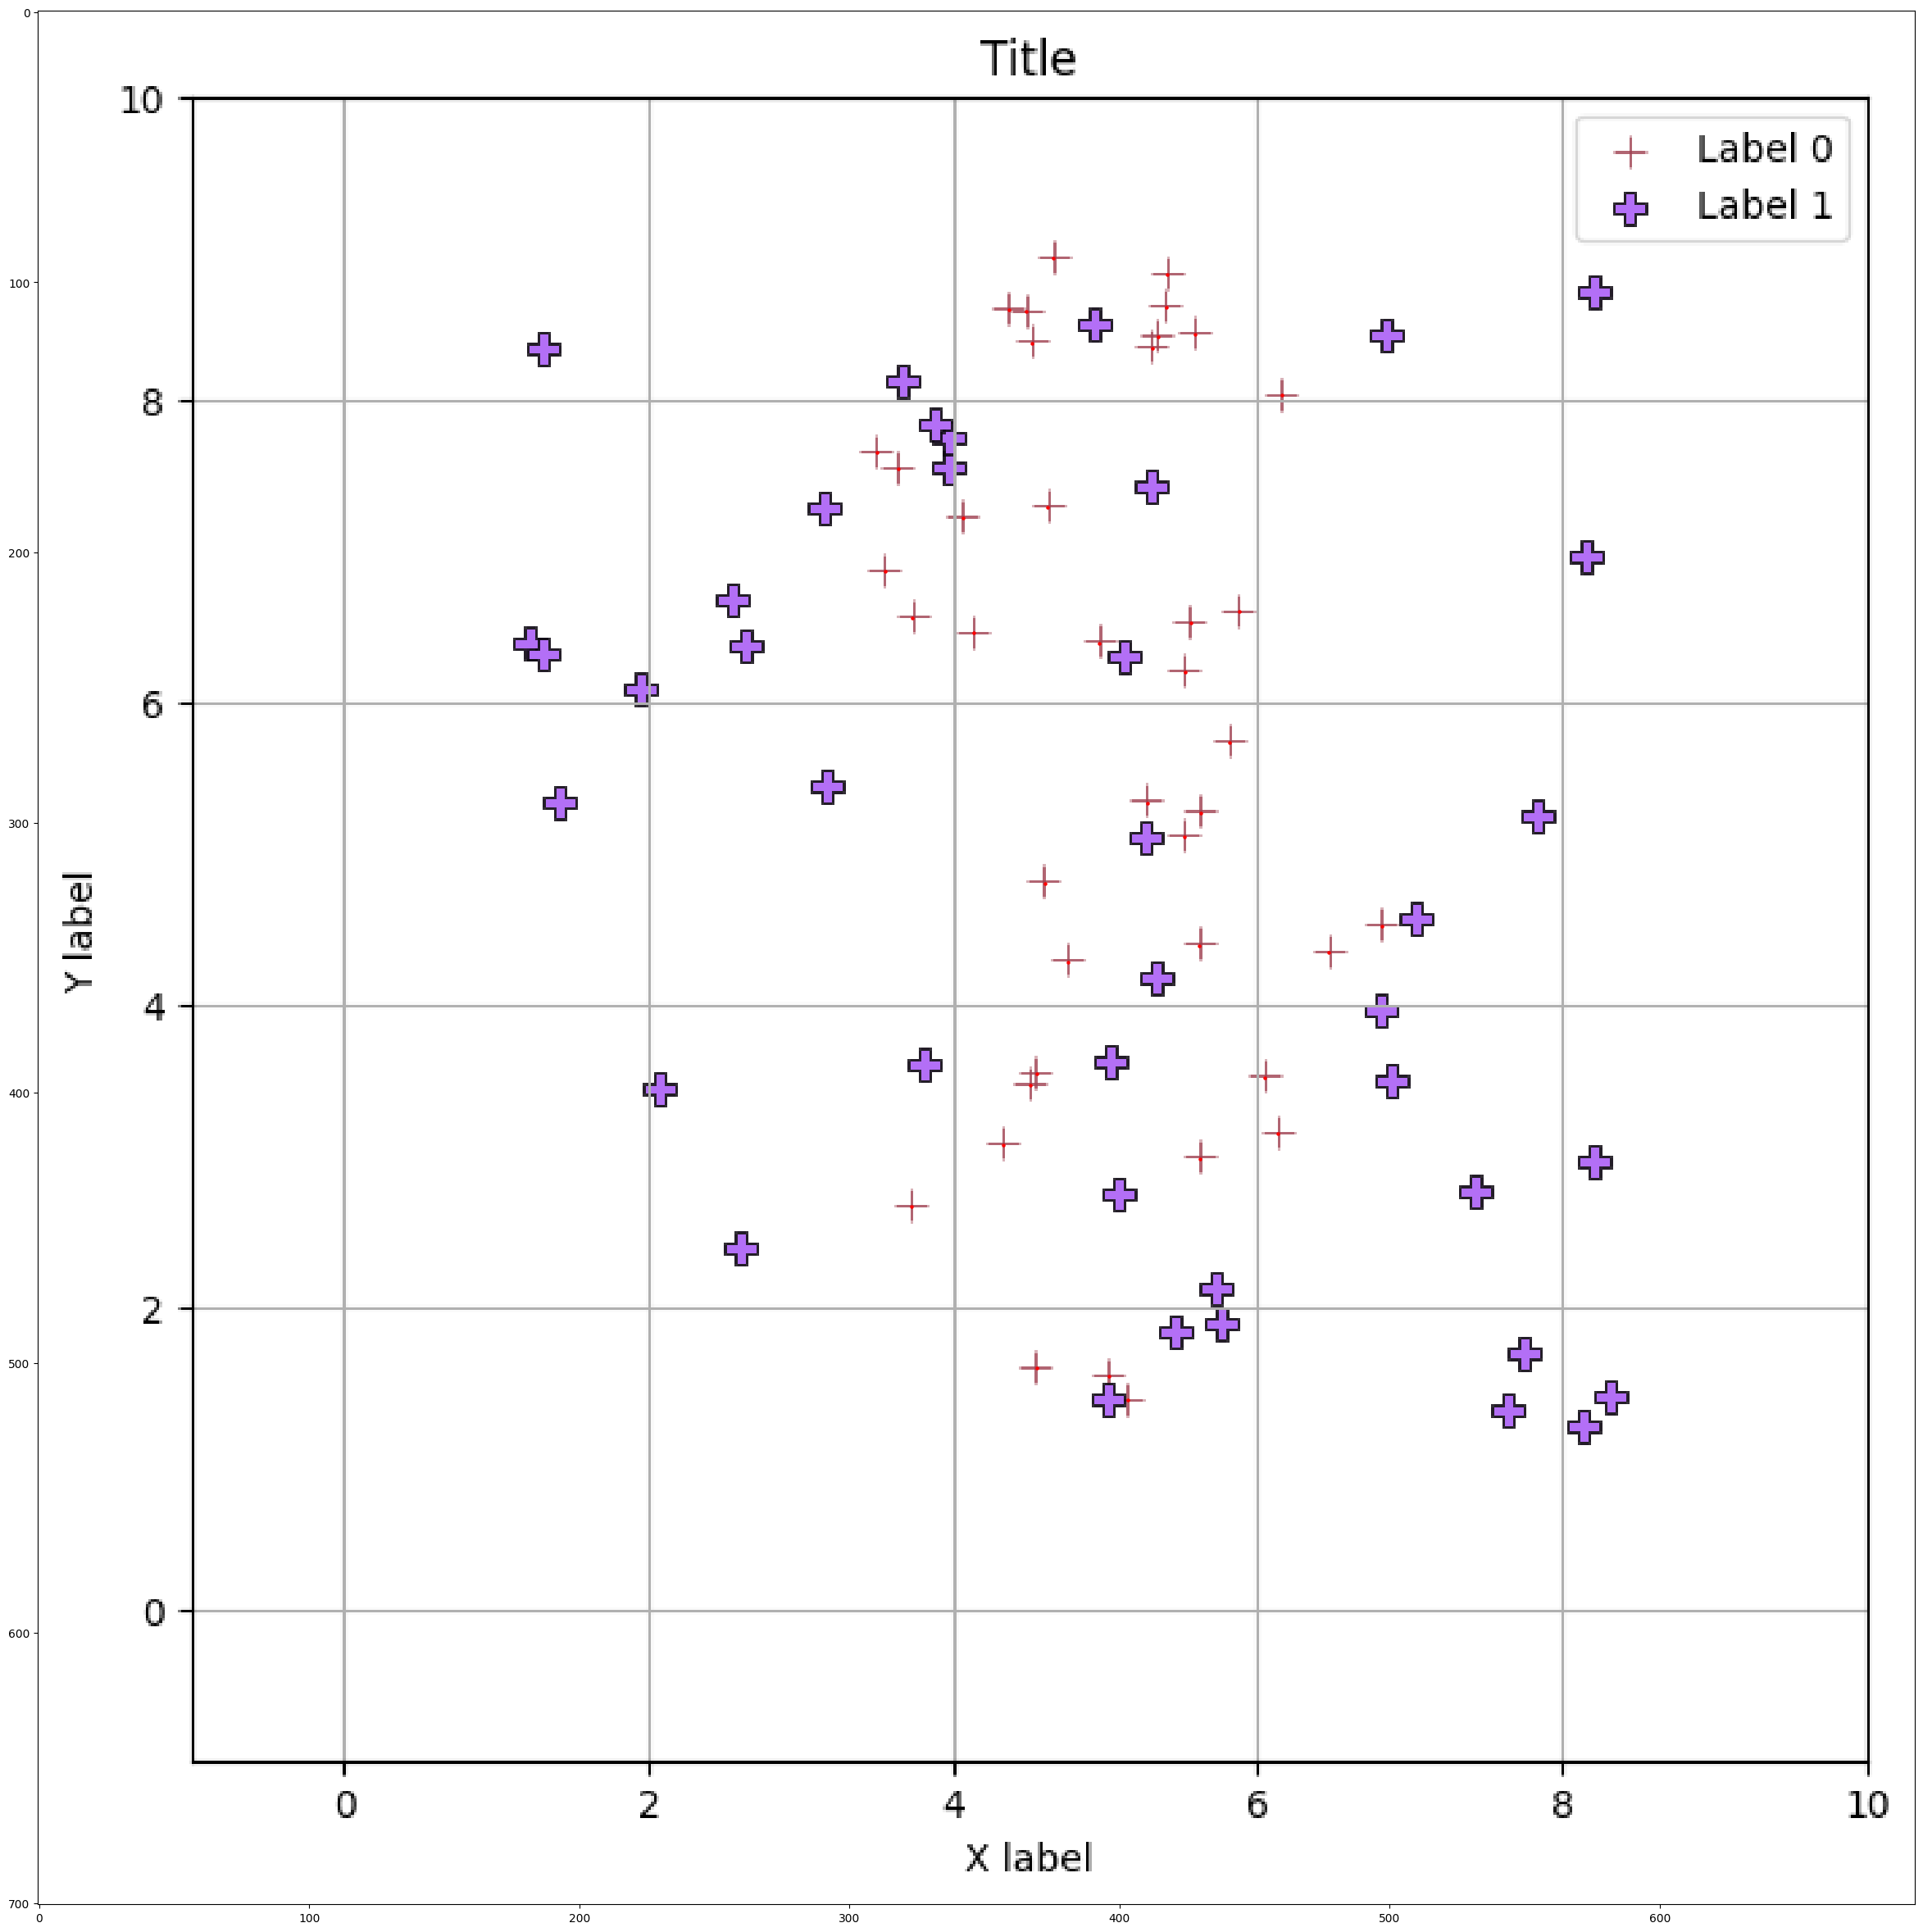

In [128]:
plt.figure(figsize=(30, 30))

plt.imshow(img)

plt.scatter(x, y, color="red", s=5)

## Estimate quiality

In [10]:
TRUE_POINTS_PATH = DATA_PATH / "generated_plots"
DETECTED_POINTS_PATH = DATA_PATH / "generated_plots" / "detected_coordinates"

In [23]:
PLOT_NUMBER = 4
MARKER_NUMBER = 0

PLOT_PATH = TRUE_POINTS_PATH / f"plot_{PLOT_NUMBER}.png"

points_true = np.loadtxt(
    TRUE_POINTS_PATH / f"plot_{PLOT_NUMBER}_coordinates_marker_{MARKER_NUMBER}.csv", 
    dtype=np.float64, 
    delimiter=","
)

points_detected = np.loadtxt(
    DETECTED_POINTS_PATH / f"plot_{PLOT_NUMBER}_detected_coordinates_marker_{MARKER_NUMBER}_SQDIFF.csv", 
    dtype=np.float64, 
    delimiter=","
)

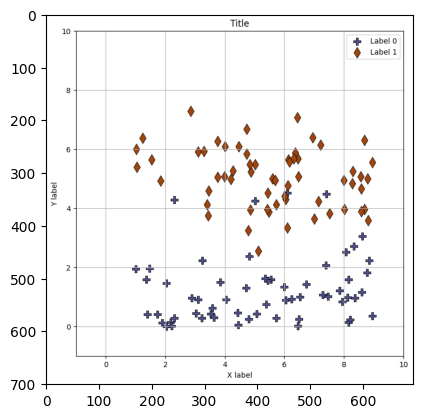

In [24]:
source_image = img = cv.imread(str(PLOT_PATH))

plt.imshow(cv.cvtColor(source_image, cv.COLOR_BGR2RGB))

Text(0.5, 1.0, 'Detected points')

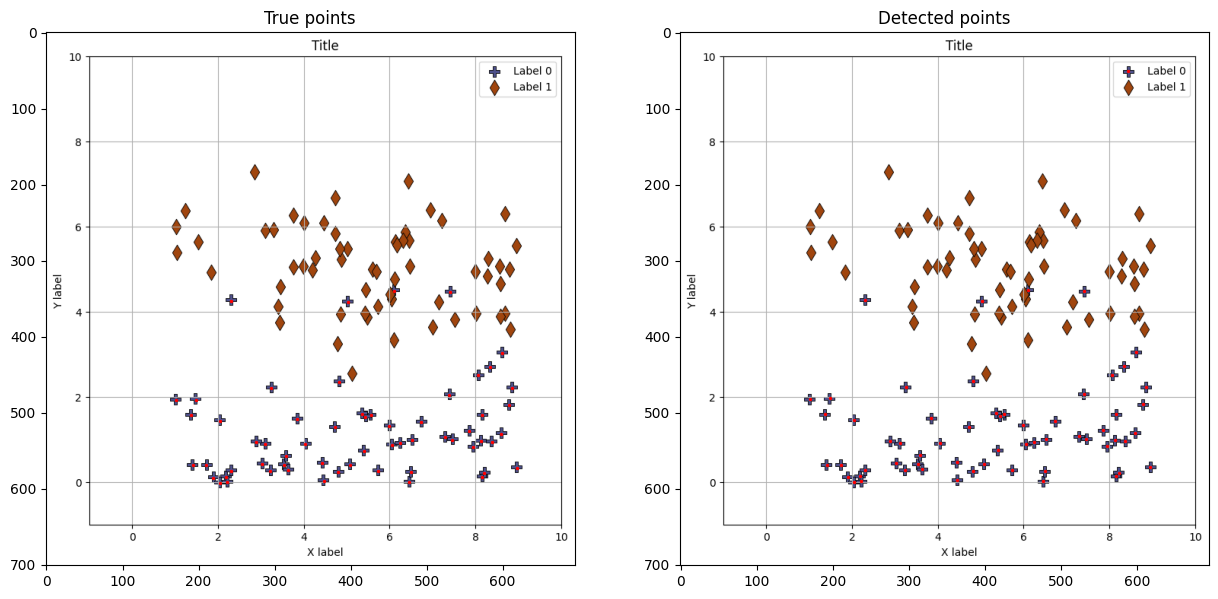

In [25]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(source_image, cv.COLOR_BGR2RGB))
plt.scatter(points_true[:, 0], points_true[:, 1], s=2, color="red")
plt.title("True points")

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(source_image, cv.COLOR_BGR2RGB))
plt.scatter(points_detected[:, 0], points_detected[:, 1], s=2, color="red")
plt.title("Detected points")

(-0.5, 694.5, 700.5, -0.5)

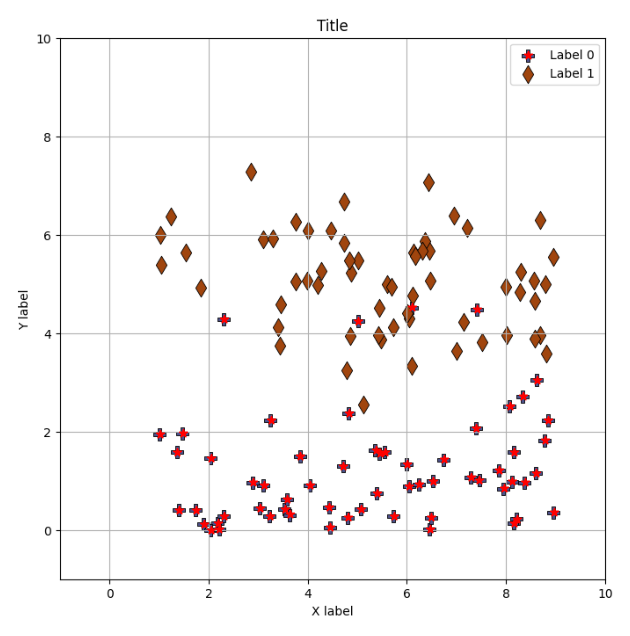

In [26]:
plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(source_image, cv.COLOR_BGR2RGB))
plt.scatter(points_detected[:, 0], points_detected[:, 1], s=35, color="red", marker="*")
plt.axis("off")

In [29]:
from scipy.spatial import distance

def compute_distances(points: np.ndarray, target_point: Tuple[float, float]) -> float:

    distances = np.zeros(len(points))
    for i, point in enumerate(points):
        distances[i] = distance.euclidean(point, target_point)
    
    return distances

In [30]:
quality_tolerance_px = 5
detected_points_counts = []


for true_point in points_true:
    distances = compute_distances(points_detected, true_point)
    
    # amount of detected points near true point
    points_count = np.sum(distances < quality_tolerance_px)
    detected_points_counts.append(points_count)
    
detected_points_counts = np.array(detected_points_counts)

In [31]:
quality_tolerance_px = 5
true_points_counts = []


for detected_point in points_detected:
    distances = compute_distances(points_true, detected_point)
    
    # amount of true points near detected point
    points_count = np.sum(distances < quality_tolerance_px)
    true_points_counts.append(points_count)
    
true_points_counts = np.array(true_points_counts)

In [32]:
true_points_counts

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1])

In [33]:
detected_points_counts

array([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0])

In [34]:
successfully_detected_points_count = len(np.where(detected_points_counts == 1)[0])
missed_points_count = len(np.where(detected_points_counts == 0)[0])
overdetected_points_count = len(np.where(detected_points_counts > 1)[0])
fake_detection_count = len(np.where(true_points_counts == 0)[0])

print("Successfull detection percentage:", successfully_detected_points_count / len(points_true))
print()
print("Number of true points, that were not detected:", missed_points_count)
print("Number of true points, that has more than one detection:", overdetected_points_count)
print("Number of detected points, that has wrong detection:", fake_detection_count)

Successfull detection percentage: 0.5384615384615384

Number of true points, that were not detected: 18
Number of true points, that has more than one detection: 0
Number of detected points, that has wrong detection: 3


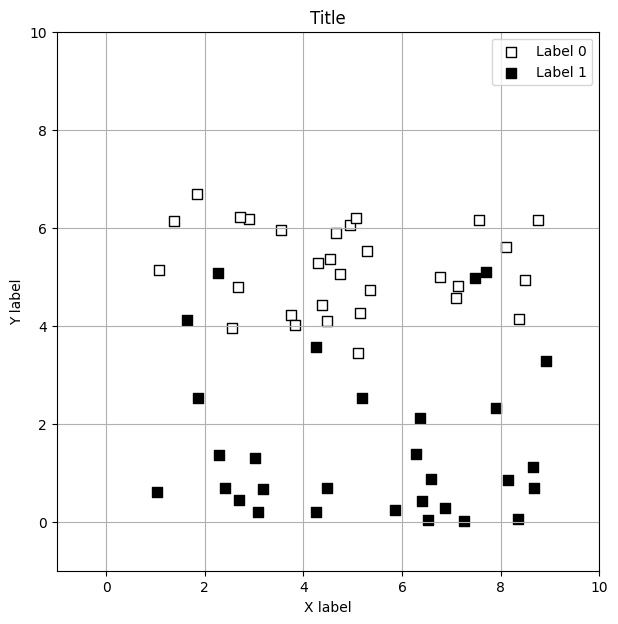

In [22]:
colors_list = ["white", "black", "black"]
marker_types = ["s", "s", "o"]

fig = plt.figure(figsize=(7, 7))

for j in range(2):
    x, y = generate_points(30, distributions)
    points_single_marker = np.stack((x, y)).T

    color = colors_list[j]
    marker = marker_types[j]
    plt.scatter(x, y,
                s=60,
                c=color,
                marker=marker,
                cmap=None,
                edgecolors='black',
                linewidths=1,
                label=f"Label {j}")
    all_points.append(points_single_marker)
plt.title("Title")
plt.xlabel("X label")
plt.ylabel("Y label")
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.grid()
plt.legend()

In [29]:
fig.savefig("/mnt/c/Users/admin/Desktop/example.png", dpi=200)

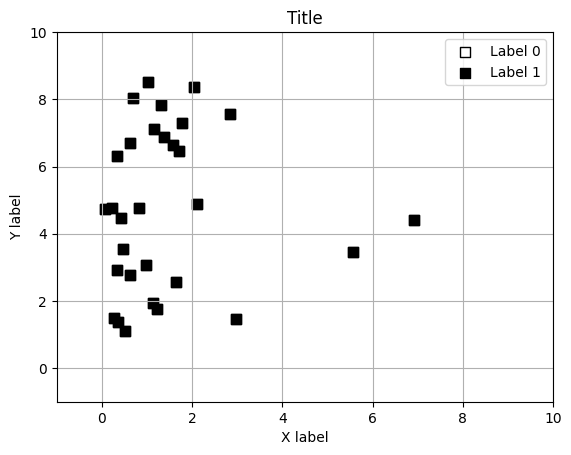

In [20]:
for j in range(2):
    # x, y = generate_points(30, distributions)
    points_single_marker = np.stack((x, y)).T

    color = colors_list[j]
    marker = marker_types[j]
    plt.scatter(x, y,
                s=60,
                c=color,
                marker=marker,
                cmap=None,
                edgecolors='black',
                linewidths=1,
                label=f"Label {j}")
    all_points.append(points_single_marker)
plt.title("Title")
plt.xlabel("X label")
plt.ylabel("Y label")
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.grid()
plt.legend()

# Detections results (for diploma) 

In [5]:
from template_match import read_image_rgb

In [6]:
def draw_image(image: np.ndarray) -> None:
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

In [955]:
PLOT_NUMBER = 48
MARKER_NUMBER = 2

PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "markers_same_shape" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"
COORDS_PATH = DATA_PATH / "results" / "coordinates_detected_csv" / "SQDIFF_MODIFICATION_V2" / f"coords_plot{PLOT_NUMBER}_marker{MARKER_NUMBER}_SQDIFF_MODIFICATION_V2.csv"

In [956]:
SAVEPATH = "/mnt/c/Users/admin/Desktop/diplom_strata/diplom_tex/images/appendix_imges/"

In [957]:
source_image = read_image_rgb(PLOT_PATH)
template_rgb = read_image_rgb(TEMPLATE_PATH)

points = np.loadtxt(
    COORDS_PATH, 
    dtype=np.float64, 
    delimiter=","
)

Text(0.5, 0, '(б)')

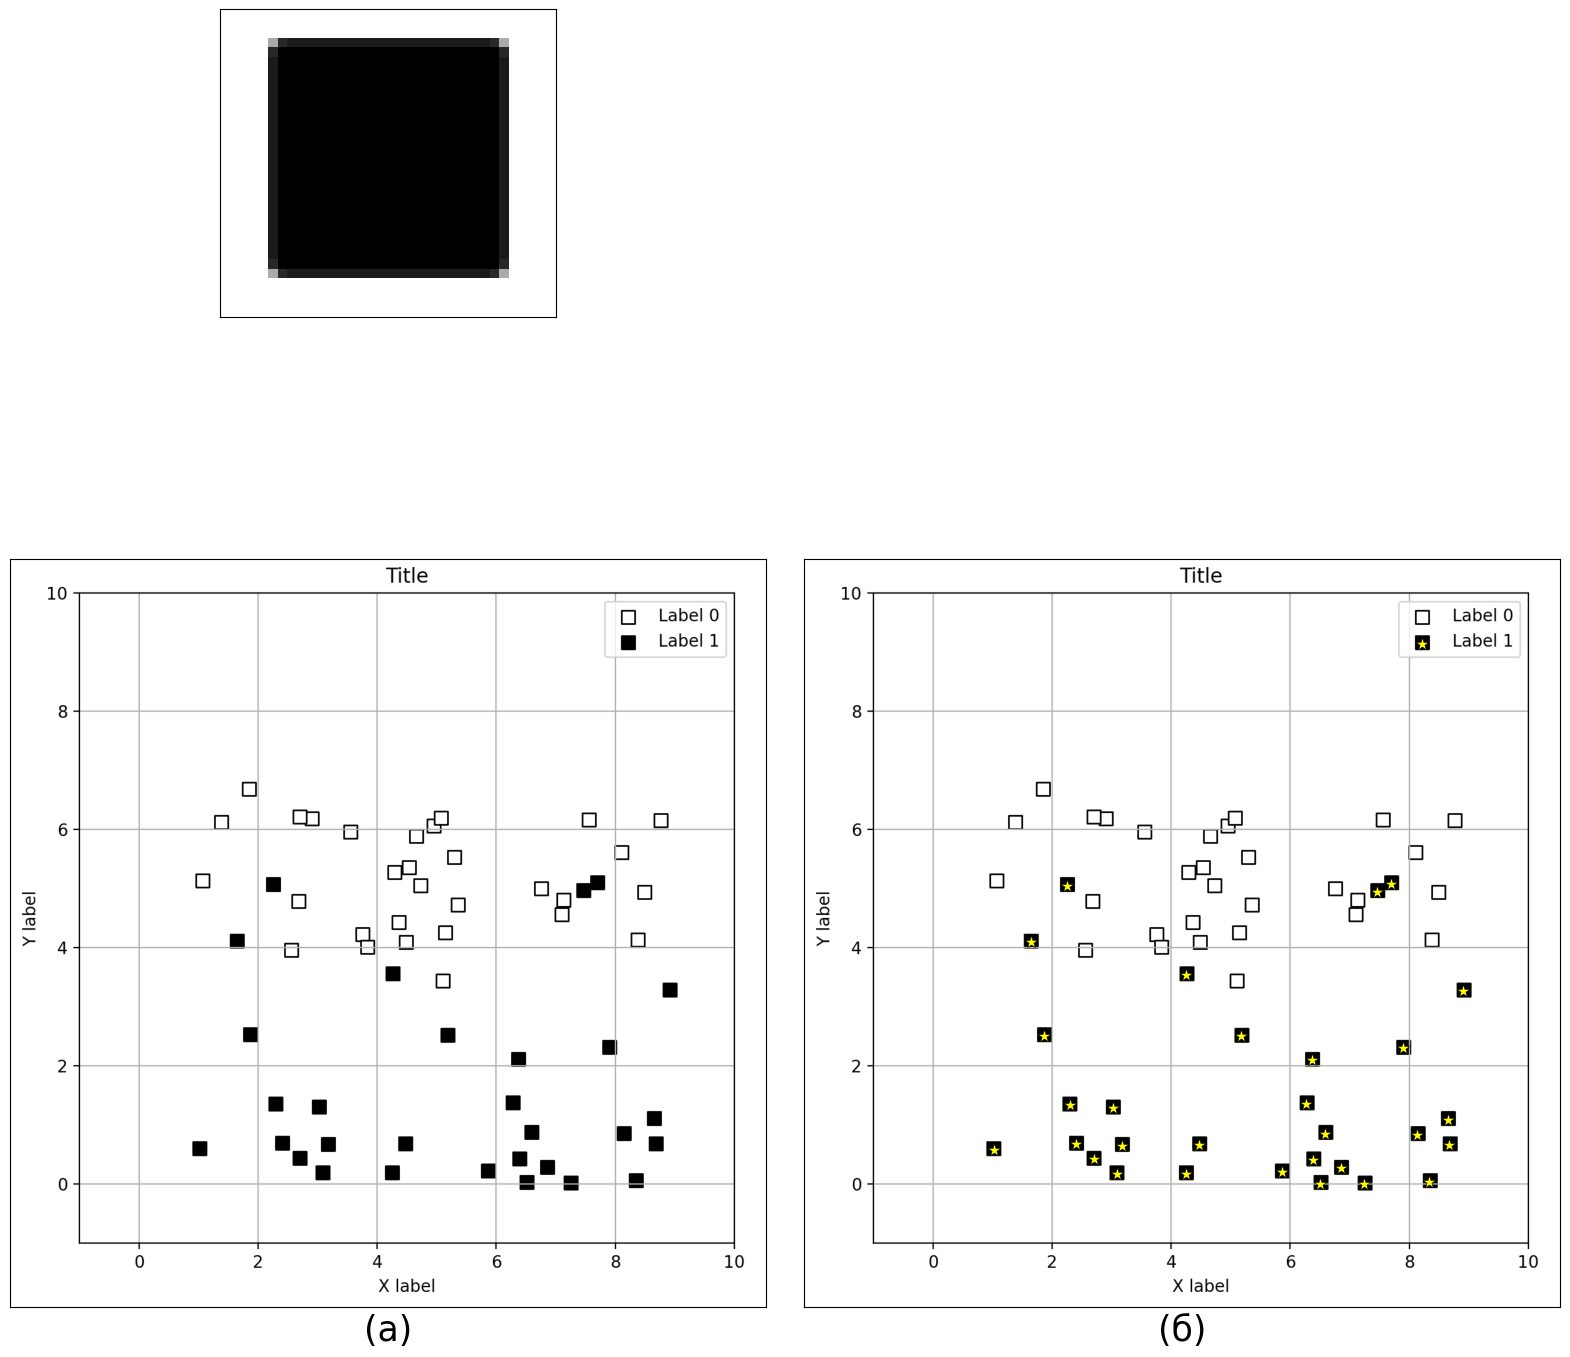

In [958]:
MARKER_SIZE = 90
MARKER_COLOR = "yellow"


from matplotlib import gridspec
 
fig = plt.figure(figsize=(20, 20))
 
spec = gridspec.GridSpec(ncols=2, nrows=2,
                         width_ratios=[1, 1], wspace=0.05,
                         hspace=0.000001, height_ratios=[1, 4])
 
 
ax1 = fig.add_subplot(spec[0])
draw_image(template_rgb)
plt.xticks([]); plt.yticks([]);

ax2 = fig.add_subplot(spec[1])
ax2.imshow(np.zeros_like(template_rgb) + 255)
plt.axis("off")
 
ax3 = fig.add_subplot(spec[2])
draw_image(source_image)
plt.xticks([]); plt.yticks([]);
plt.xlabel('(а)', fontsize=25)

ax4 = fig.add_subplot(spec[3])
draw_image(source_image)
ax4.scatter(points[:, 0], points[:, 1], s=MARKER_SIZE, c=MARKER_COLOR, marker="*",  edgecolors='black', linewidths=0.4)
plt.xticks([]); plt.yticks([]);
plt.xlabel('(б)', fontsize=25)

In [959]:
fig.savefig(SAVEPATH + f"detections_plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png", bbox_inches='tight')

In [960]:
latex_image_paste=f"""\\begin{{figure}}   [h!]
\\begin{{center}}
\includegraphics[scale=0.45]{{appendix_images/detections_plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png}}
\end{{center}}
\caption{{Диаграмма {PLOT_NUMBER}, маркер {MARKER_NUMBER}: исходное изображение и шаблон (а), результат детекции (желтые точки) (б).}}
\label{{fig:detections_plot{PLOT_NUMBER}_marker{MARKER_NUMBER}}}
\end{{figure}}



"""

In [961]:

with open(SAVEPATH + "appendix.tex", "a") as f:
    f.write(latex_image_paste)